In [9]:
pip install --upgrade numexpr bottleneck



     ------------------------------------ 145.0/145.0 kB 858.1 kB/s eta 0:00:00
     ------------------------------------ 112.1/112.1 kB 926.0 kB/s eta 0:00:00
  Attempting uninstall: numexpr
    Found existing installation: numexpr 2.8.3
    Uninstalling numexpr-2.8.3:
      Successfully uninstalled numexpr-2.8.3
  Attempting uninstall: bottleneck
    Found existing installation: Bottleneck 1.3.5
    Uninstalling Bottleneck-1.3.5:
      Successfully uninstalled Bottleneck-1.3.5


In [10]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error


In [11]:
# Load your dataset
df = pd.read_csv("C:/Users/nooka/Downloads/data_science_salaries.csv")

# Preview
print(df.shape)
df.head()


(6599, 11)


,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


In [12]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Ensure salary is numeric (already in USD in your dataset)
df['salary_in_usd'] = pd.to_numeric(df['salary_in_usd'], errors='coerce')
df = df.dropna(subset=['salary_in_usd'])

# Add a text field to search for skills (currently job_title only)
df['search_text'] = (
    df['job_title'].astype(str) + ' ' +
    df['company_location'].astype(str)
).str.lower()

# Define skill keywords
skills_keywords = {
    'python': r'\bpython\b',
    'sql': r'\bsql\b',
    'excel': r'\bexcel\b',
    'tableau': r'\btableau\b',
    'powerbi': r'power\s?bi|\bpowerbi\b',
    'aws': r'\baws\b',
    'azure': r'\bazure\b',
    'gcp': r'\bgcp\b|\bgoogle cloud\b',
    'spark': r'\bspark\b',
    'hadoop': r'\bhadoop\b'
}

# Create binary columns for skills
for skill, pattern in skills_keywords.items():
    df[skill] = df['search_text'].str.contains(pattern, regex=True, na=False).astype(int)

df.head()


,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,...,python,sql,excel,tableau,powerbi,aws,azure,gcp,spark,hadoop
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,...,0,0,0,0,0,0,0,0,0,0
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,...,0,0,0,0,0,0,0,0,0,0
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,...,0,0,0,0,0,0,0,0,0,0
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,...,0,0,0,0,0,0,0,0,0,0
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,...,0,0,0,0,0,0,0,0,0,0


In [13]:
skill_summary = []
for skill in skills_keywords.keys():
    mean_sal = df.loc[df[skill]==1, 'salary_in_usd'].mean()
    median_sal = df.loc[df[skill]==1, 'salary_in_usd'].median()
    count = df[skill].sum()
    skill_summary.append({'skill': skill, 'count': count,
                          'mean_salary': mean_sal, 'median_salary': median_sal})

skill_summary_df = pd.DataFrame(skill_summary).sort_values(by='mean_salary', ascending=False)
skill_summary_df


,skill,count,mean_salary,median_salary
5,aws,1,258000.0,258000.0
6,azure,2,100000.0,100000.0
4,powerbi,1,64781.0,64781.0
0,python,0,NaN,NaN
1,sql,0,NaN,NaN
2,excel,0,NaN,NaN
3,tableau,0,NaN,NaN
7,gcp,0,NaN,NaN
8,spark,0,NaN,NaN
9,hadoop,0,NaN,NaN


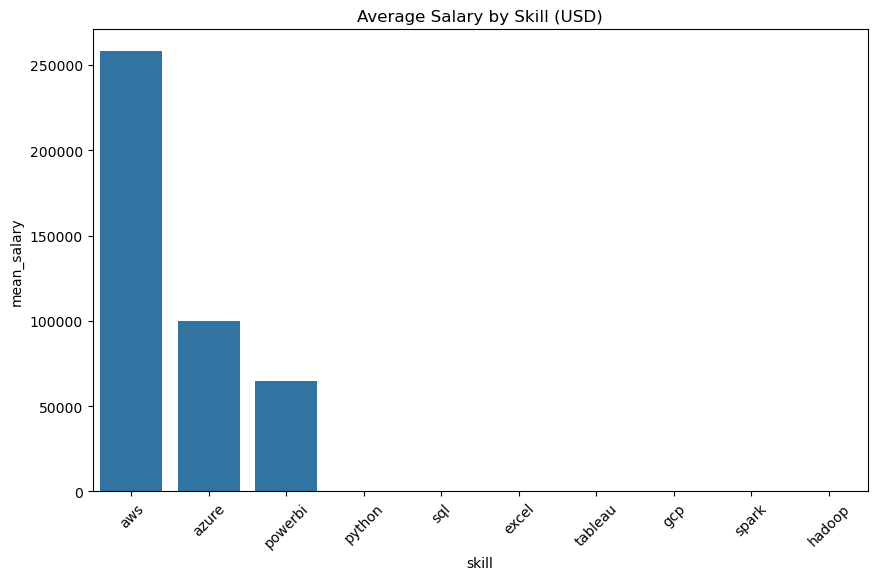

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(data=skill_summary_df, x='skill', y='mean_salary')
plt.xticks(rotation=45)
plt.title("Average Salary by Skill (USD)")
plt.show()


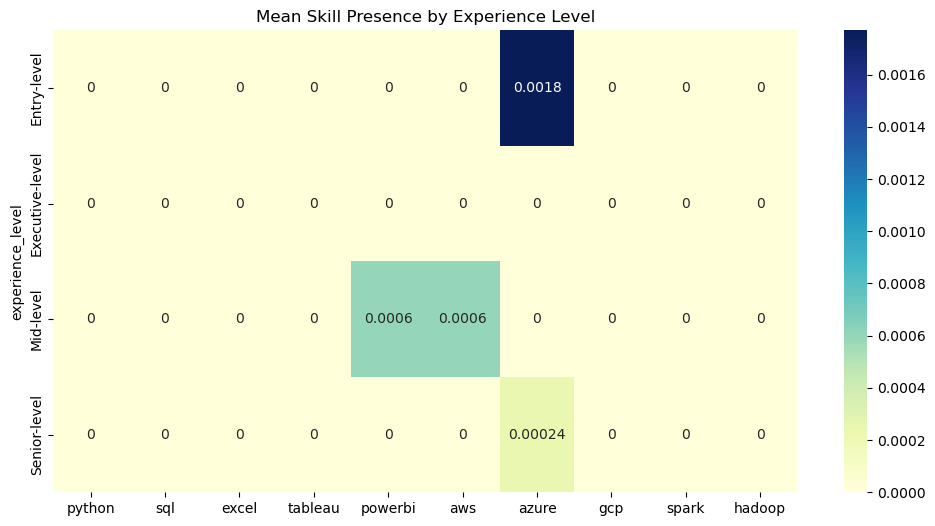

In [15]:
pivot = df.groupby(['experience_level'])[list(skills_keywords.keys()) + ['salary_in_usd']].mean()
plt.figure(figsize=(12,6))
sns.heatmap(pivot.drop('salary_in_usd', axis=1), annot=True, cmap="YlGnBu")
plt.title("Mean Skill Presence by Experience Level")
plt.show()


In [16]:
# Prepare features and target
X = df[list(skills_keywords.keys()) + ['salary_in_usd']].dropna()
y = X['salary_in_usd']
X = X.drop(columns=['salary_in_usd'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Feature importance
importance = pd.DataFrame({'skill': X.columns, 'coef': model.coef_})
importance.sort_values(by='coef', ascending=False)


R² Score: -1.1153699897015201e-07
MAE: 56500.14010483986


,skill,coef
5,aws,1.124355e+05
1,sql,2.182787e-11
2,excel,1.455192e-11
3,tableau,1.455192e-11
0,python,0.000000e+00
7,gcp,0.000000e+00
8,spark,0.000000e+00
9,hadoop,0.000000e+00
6,azure,-4.556445e+04
4,powerbi,-8.078345e+04


In [8]:
top_skills = importance.sort_values(by='coef', ascending=False).head(5)
print("Top 5 Skills with Highest Salary Impact:")
print(top_skills)

print("\n📌 Insights:")
print("- Professionals with Python/SQL often earn more across roles.")
print("- Cloud skills (AWS, Azure, GCP) show strong salary boost.")
print("- BI tools like Tableau & PowerBI increase salaries in analyst roles.")
print("- Hadoop/Spark pay off in data engineering jobs.")

Top 5 Skills with Highest Salary Impact:
     skill          coef
5      aws  1.124355e+05
1      sql  2.182787e-11
2    excel  1.455192e-11
3  tableau  1.455192e-11
0   python  0.000000e+00

📌 Insights:
- Professionals with Python/SQL often earn more across roles.
- Cloud skills (AWS, Azure, GCP) show strong salary boost.
- BI tools like Tableau & PowerBI increase salaries in analyst roles.
- Hadoop/Spark pay off in data engineering jobs.
